In [1]:
!nvidia-smi

Wed Mar 17 11:17:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |   4335MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:07:00.0 Off |                  N/A |
| 23%   31C    P8     8W / 250W |   3415MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
!pip install -q transformers==4.2.0
!pip install -q biopython
!pip install -q sklearn_crfsuite

In [3]:
import torch

if torch.cuda.is_available():    
   
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU memory:', torch.cuda.get_device_properties(device).total_memory/(1024**3), "GB")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU memory: 10.91650390625 GB


In [4]:
# !pip install transformers

In [5]:
import os
file_list = list()

for root, dirs, files in os.walk("raw_data/train"):
    file_list = files
    print(files)
    break

print("find files below:")
for i in range(len(file_list)):
    print((i+1), ". ", file_list[i])

['label_藏富卡旺_0306c.bio', 'label_雙盈雙利_0306c.bio', 'label_添美好_new_0306.bio', 'label_鑫美利_0306c.bio', 'fake_data.bio', 'label_美年旺_0306C.bio']
find files below:
1 .  label_藏富卡旺_0306c.bio
2 .  label_雙盈雙利_0306c.bio
3 .  label_添美好_new_0306.bio
4 .  label_鑫美利_0306c.bio
5 .  fake_data.bio
6 .  label_美年旺_0306C.bio


In [6]:
import csv
from sklearn.model_selection import train_test_split

sentences = []
labels = []

tokens = []
token_labels = []

sentences_o = []
labels_o = []

for file_name in file_list:
    if file_name != "fake_data.bio":
        with open("raw_data/train/%s" % file_name, newline = '') as lines:                                                                                          

            line_reader = csv.reader(lines, delimiter='\t')

            for line in line_reader:

                if line == []:

                    if tokens:
                        n = 0
                        for token_label in token_labels:
                            if token_label != "o":
                                n += 1

                        if n != 0:

                            sentences.append(tokens)
                            labels.append(token_labels)

                        else:
                            sentences_o.append(tokens)
                            labels_o.append(token_labels)

                    tokens = []
                    token_labels = []        

                else: 

                    tokens.append(line[1])
                    token_labels.append(line[0])
                    
    else:
        with open("raw_data/train/%s" % file_name, newline = '') as lines:                                                                                          

            line_reader = csv.reader(lines, delimiter='\t')

            for line in line_reader:

                if line == []:

                    if tokens:
                        n = 0
                        for token_label in token_labels:
                            n += 1

                        if n != 0:

                            sentences.append(tokens)
                            labels.append(token_labels)           

                    tokens = []
                    token_labels = []        

                else: 

                    tokens.append(line[1])
                    token_labels.append(line[0])

    print(file_name + " is finish!")
    print("Total number of sentences so far: ", len(sentences))
    

sentences_o_picked, sentences_o_unpicked, labels_o_picked, labels_o_unpicked = train_test_split(
sentences_o, labels_o, test_size = 0.75, random_state = 10)

for sen in sentences_o_picked:
    sentences.append(sen)
for label in labels_o_picked:
    labels.append(label)

print("Total number of all non-specific label sentences", len(sentences_o))
print("--randomly pick 50% all non-specific label sentence--")
print("Total number of sentences so far: ", len(sentences))

label_藏富卡旺_0306c.bio is finish!
Total number of sentences so far:  85
label_雙盈雙利_0306c.bio is finish!
Total number of sentences so far:  168
label_添美好_new_0306.bio is finish!
Total number of sentences so far:  266
label_鑫美利_0306c.bio is finish!
Total number of sentences so far:  342
fake_data.bio is finish!
Total number of sentences so far:  450
label_美年旺_0306C.bio is finish!
Total number of sentences so far:  528
Total number of all non-specific label sentences 794
--randomly pick 50% all non-specific label sentence--
Total number of sentences so far:  726


In [7]:
label_map = {'B-currency': 11,
 'I-rate': 10,
 'I-item': 8,
 'I-benefit': 4,
 'B-parameter': 5,
 'B-Heading': 1,
 'B-item': 7,
 'I-Heading': 2,
 'B-rate': 9,
 'I-currency': 12,
 'I-parameter': 6,
 'B-benefit': 3,
 'o': 0}

In [8]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 726


In [9]:
no_label = [0] * len(labels)
label = [0] * len(labels)
for i in range(len(labels)):
    for element in labels[i]:
        if element == "o":
            no_label[i] += 1
        else:
            label[i] += 1

ratio = [0] * len(label)
for i in range(len(label)):
    ratio[i] = label[i] / (label[i] + no_label[i])
import matplotlib.pyplot as plt
plt.plot(range(len(ratio)), ratio)

In [10]:
from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

lengths = []

print('Measuring sentence lengths...')

for sen in sentences:
    
    sen = ' '.join(sen)

    encoded_sent = tokenizer.encode(
                        sen, 
                        add_special_tokens = True, )

    lengths.append(len(encoded_sent))

print('    DONE.')

Measuring sentence lengths...
    DONE.


In [11]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 7 tokens
   Max length: 289 tokens
Median length: 66 tokens


Text(0, 0.5, '# of Sentences')

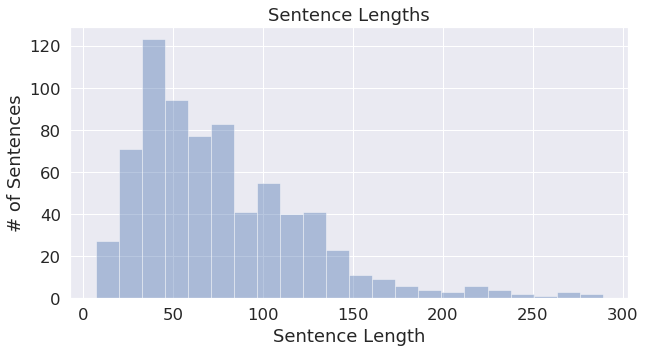

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')

In [13]:
sen_index = 0
remove_index_in_sentences = []
for i in range(len(sentences)):
    if len(sentences[i]) > 500:
        print("No.", i, "sen. have", len(sentences[i]), "tokens")
        remove_index_in_sentences.append(i)
    sen_index += 1
print(remove_index_in_sentences)

[]


In [14]:
import numpy as np
for i in range(len(remove_index_in_sentences)):
    print(remove_index_in_sentences[i])
    sentences.remove(sentences[remove_index_in_sentences[i]])
    labels.remove(labels[remove_index_in_sentences[i]])
    remove_index_in_sentences = (np.array(remove_index_in_sentences) - 1).tolist()
    print(remove_index_in_sentences)

In [15]:
input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(
                        sent_str,
                        add_special_tokens = True, 
                        truncation = True,
                        max_length = 500, 
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'][0])

    attention_masks.append(encoded_dict['attention_mask'][0])

for sens,tokens,masks in zip(sentences[1],input_ids[1],attention_masks[1]):
    print('({0}, {1}, {2})'.format(sens,tokens,masks))

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(【, 101, 1)
(本, 523, 1)
(保, 3315, 1)
(險, 924, 1)
(為, 7402, 1)
(不, 4158, 1)
(分, 679, 1)
(紅, 1146, 1)
(保, 5148, 1)
(險, 924, 1)
(單, 7402, 1)
(】, 1606, 1)
(※, 524, 1)
(本, 349, 1)
(保, 3315, 1)
(險, 924, 1)
(為, 7402, 1)
(不, 4158, 1)
(分, 679, 1)
(紅, 1146, 1)
(保, 5148, 1)
(險, 924, 1)
(單, 7402, 1)
(，, 1606, 1)
(不, 8024, 1)
(參, 679, 1)
(加, 1347, 1)
(紅, 1217, 1)
(利, 5148, 1)
(分, 1164, 1)
(配, 1146, 1)
(，, 6981, 1)
(並, 8024, 1)
(無, 699, 1)
(紅, 4192, 1)
(利, 5148, 1)
(給, 1164, 1)
(付, 5183, 1)
(項, 802, 1)
(目, 7517, 1)
(。, 4680, 1)


In [16]:
new_labels = []

null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):

    padded_labels = []

    orig_labels_i = 0 

    for token_id in sen:

        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):

            padded_labels.append(null_label_id)

        else:

            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    

    new_labels.append(padded_labels)

In [17]:
label_map['none']=-100
key_list=list(label_map.keys())
value_list=list(label_map.values())
print(key_list[value_list.index(-100)])
print(label_map)

for ids,nl,ma in zip(input_ids[1],new_labels[1],attention_masks[1]):
    if ma==0:
        break
    print('({0}, {1}, {2})'.format(ids,key_list[value_list.index(nl)],ma))
print('--------------------')
del label_map['none']
print(label_map)

none
{'B-currency': 11, 'I-rate': 10, 'I-item': 8, 'I-benefit': 4, 'B-parameter': 5, 'B-Heading': 1, 'B-item': 7, 'I-Heading': 2, 'B-rate': 9, 'I-currency': 12, 'I-parameter': 6, 'B-benefit': 3, 'o': 0, 'none': -100}
(101, none, 1)
(523, B-Heading, 1)
(3315, I-Heading, 1)
(924, I-Heading, 1)
(7402, I-Heading, 1)
(4158, I-Heading, 1)
(679, I-Heading, 1)
(1146, I-Heading, 1)
(5148, I-Heading, 1)
(924, I-Heading, 1)
(7402, I-Heading, 1)
(1606, I-Heading, 1)
(524, I-Heading, 1)
(349, o, 1)
(3315, o, 1)
(924, o, 1)
(7402, o, 1)
(4158, o, 1)
(679, o, 1)
(1146, o, 1)
(5148, o, 1)
(924, o, 1)
(7402, o, 1)
(1606, o, 1)
(8024, o, 1)
(679, o, 1)
(1347, o, 1)
(1217, o, 1)
(5148, o, 1)
(1164, o, 1)
(1146, o, 1)
(6981, o, 1)
(8024, o, 1)
(699, o, 1)
(4192, o, 1)
(5148, o, 1)
(1164, o, 1)
(5183, o, 1)
(802, o, 1)
(7517, o, 1)
(4680, o, 1)
(511, o, 1)
(102, none, 1)
--------------------
{'B-currency': 11, 'I-rate': 10, 'I-item': 8, 'I-benefit': 4, 'B-parameter': 5, 'B-Heading': 1, 'B-item': 7, 'I-Head

In [18]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)
print(pt_input_ids.shape)
print(pt_attention_masks.shape)
print(pt_labels.shape)

torch.Size([726, 500])
torch.Size([726, 500])
torch.Size([726, 500])


In [19]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

  653 training samples
   73 validation samples


In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 1

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

In [21]:
from transformers import BertForTokenClassification, AdamW, BertConfig
import torch.nn as nn

model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels = len(label_map) + 1, 
    output_attentions = False, 
    output_hidden_states = False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model.to(device)
model.cuda()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

DataParallel(
  (module): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(21128, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (La

In [22]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [23]:
import time
import numpy as np
import datetime

def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
val_loss_values=[]

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0
    total_val_loss=0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

        loss_backward = result.loss
        result.loss = result.loss.cpu().detach().numpy()
        loss = result.loss
        total_loss += loss

        loss_backward.mean().backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()


    model.eval()
    for step, batch in enumerate(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        result.loss = result.loss.cpu().detach().numpy()
        val_loss = result.loss
        total_val_loss += val_loss

    avg_train_loss = total_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(validation_dataloader)

    loss_values.append(avg_train_loss)
    val_loss_values.append(avg_val_loss)

    print("")
    print("  Average training loss: {0:.4f}".format(np.mean(avg_train_loss)))
    print("  Average validation loss: {0:.4f}".format(np.mean(avg_val_loss)))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



  Average training loss: 0.1212
  Average validation loss: 0.0419
  Training epcoh took: 0:01:21

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.0263
  Average validation loss: 0.0014
  Training epcoh took: 0:01:20

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.0173
  Average validation loss: 0.0009
  Training epcoh took: 0:01:20

Training complete!


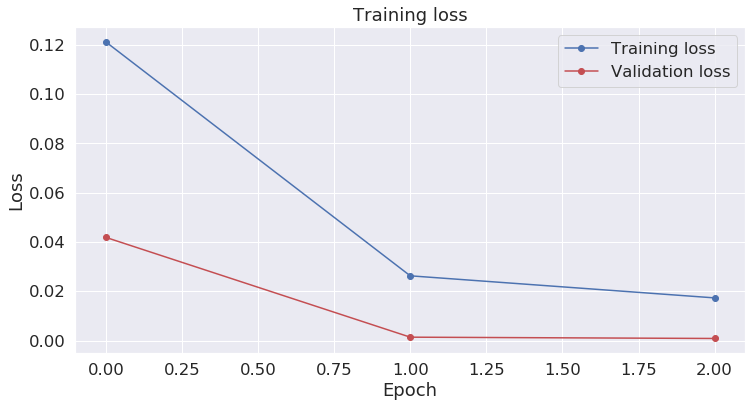

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o',label='Training loss')
plt.plot(val_loss_values,'r-o',label='Validation loss')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [26]:
import os

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [27]:
!nvidia-smi

Wed Mar 17 11:22:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 46%   71C    P2    67W / 250W |   8208MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:07:00.0 Off |                  N/A |
| 23%   28C    P8     8W / 250W |   3415MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G